<a href="https://colab.research.google.com/github/Bertaalcolea/Collagen_studies/blob/main/Ionic(25-11vs5-12).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Collgen_NaCl_KCl_Study1 (1).xlsx to Collgen_NaCl_KCl_Study1 (1) (2).xlsx
Saving Collgen_NaCl_KCl_Study2.xlsx to Collgen_NaCl_KCl_Study2 (1).xlsx
Archivo 25-11: Collgen_NaCl_KCl_Study1 (1) (2).xlsx
Archivo 5-12 : Collgen_NaCl_KCl_Study2 (1).xlsx
Resumen condiciones unificadas:
      study  species  salt        conc      pH_group                     cond
4734   5-12   Bovine   KCl      137 mM          pH 6       Bov KCl 137 mM pH6
18    25-11   Bovine   KCl      137 mM  unaltered/NA        Bovine KCl 137 mM
24    25-11   Bovine   KCl      200 mM  unaltered/NA        Bovine KCl 200 mM
4728   5-12   Bovine   KCl      200 mM  unaltered/NA           Bov KCl 200 mM
30    25-11   Bovine   KCl  Commercial  unaltered/NA    Bovine KCl Commercial
4722   5-12   Bovine   KCl  Commercial  unaltered/NA       Bov KCl commercial
4752   5-12      Rat   KCl      137 mM          pH 6       Rat KCl 137 mM pH6
0     25-11      Rat   KCl      137 mM  unaltered/NA           Rat KCl 137 mM
6     25-11   

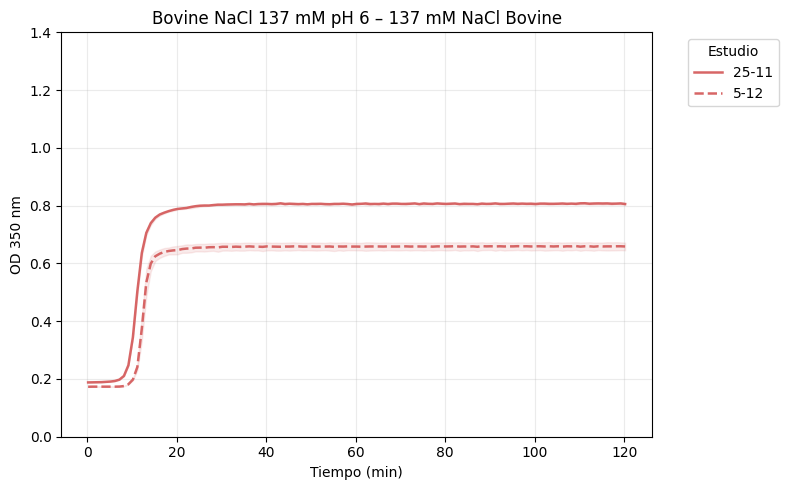

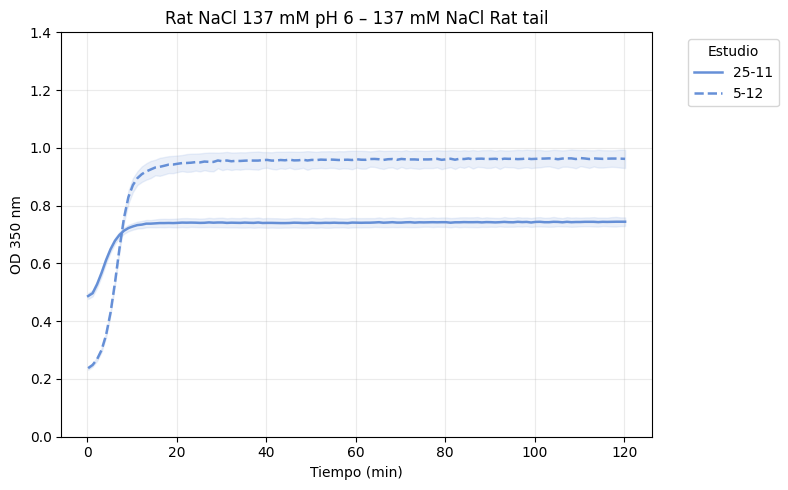

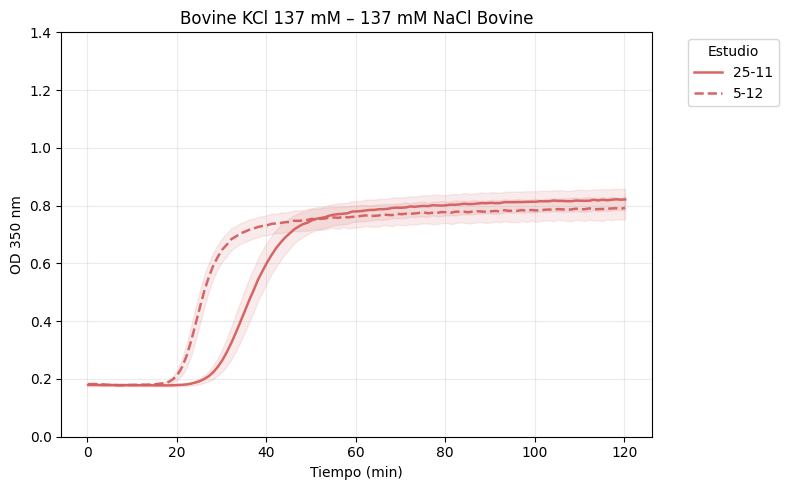

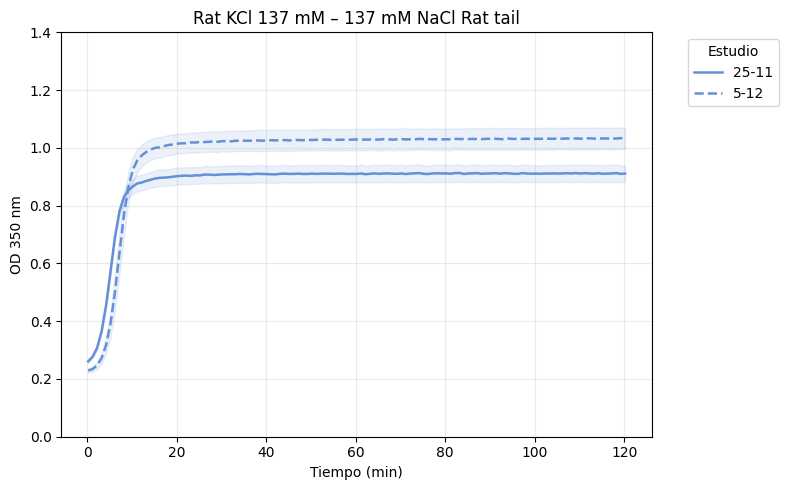

In [4]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# ====== localizar archivos de cada estudio ======
filenames = list(uploaded.keys())

file_25_11 = [f for f in filenames if "Study1" in f or "25" in f][0]
file_5_12  = [f for f in filenames if "Study2" in f or "5-12" in f or "05" in f][0]

print("Archivo 25-11:", file_25_11)
print("Archivo 5-12 :", file_5_12)

# =========================================================
# FUNCIONES DE PARSEO COMUNES
# =========================================================

def parse_study1(filepath):
    """Tu parser del 25-11, adaptado a función."""
    raw = pd.read_excel(filepath, header=None)

    records = []
    time_rows = raw.index[
        raw[0].astype(str).str.startswith("350 - Time", na=False)
    ].tolist()

    for t_idx in time_rows:
        # tiempo en minutos
        time_str = str(raw.iloc[t_idx, 0])
        m = re.search(r"\((\d+):(\d+):(\d+)\)", time_str)
        if m:
            h, mm, ss = map(int, m.groups())
            time_min = h*60 + mm + ss/60
        else:
            time_min = np.nan

        # fila cabecera 1–12
        header_row = None
        for r in range(t_idx+1, min(t_idx+20, len(raw))):
            vals = raw.iloc[r].tolist()
            nums = []
            for v in vals:
                if isinstance(v, (int, float)) and not pd.isna(v):
                    nums.append(int(v))
                elif isinstance(v, str) and v.isdigit():
                    nums.append(int(v))
            if set(range(1, 13)).issubset(set(nums)):
                header_row = r
                break
        if header_row is None:
            continue

        header = raw.iloc[header_row]

        # columnas con 1–12
        well_cols = []
        for j, v in enumerate(header):
            if isinstance(v, (int, float)) and not pd.isna(v) and int(v) in range(1, 13):
                well_cols.append(j)
            elif isinstance(v, str) and v.isdigit() and int(v) in range(1, 13):
                well_cols.append(j)

        # filas A–H
        for offset in range(1, 9):
            rr = header_row + offset
            if rr >= len(raw):
                break
            row_label = raw.iloc[rr, 1]
            if row_label not in list("ABCDEFGH"):
                continue

            for j in well_cols:
                col_num = int(raw.iloc[header_row, j])
                od = raw.iloc[rr, j]
                if pd.isna(od):
                    continue
                records.append({
                    "time_min": time_min,
                    "row": row_label,
                    "col": col_num,
                    "OD": float(od),
                })

    long_df = pd.DataFrame(records)
    if long_df.empty:
        raise ValueError("Study1: records vacío, algo pasa con el Excel.")

    long_df["well"] = long_df["row"] + long_df["col"].astype(str)

    # ---- assign_meta tal cual lo tenías ----
    def assign_meta(row):
        r = row["row"]
        c = row["col"]

        species   = None
        salt      = None
        conc      = None
        pH_group  = "unaltered/NA"
        cond      = None

        # CONTROL (sin sal) – G1, G2, G3
        if r == "G" and c in [1, 2, 3]:
            species  = "Control"
            salt     = "None"
            conc     = None
            pH_group = "unaltered/NA"
            cond     = "Control (no salt)"
            return pd.Series({
                "species":  species,
                "salt":     salt,
                "conc":     conc,
                "pH_group": pH_group,
                "cond":     cond
            })

        # KCl – RAT (A–C, col 1–3)
        if r == "A" and c in [1, 2, 3]:
            species  = "Rat"
            salt     = "KCl"
            conc     = "137 mM"
            cond     = "Rat KCl 137 mM"
        elif r == "B" and c in [1, 2, 3]:
            species  = "Rat"
            salt     = "KCl"
            conc     = "200 mM"
            cond     = "Rat KCl 200 mM"
        elif r == "C" and c in [1, 2, 3]:
            species  = "Rat"
            salt     = "KCl"
            conc     = "Commercial"
            cond     = "Rat KCl Commercial"

        # KCl – BOVINE (D–F, col 1–3)
        elif r == "D" and c in [1, 2, 3]:
            species  = "Bovine"
            salt     = "KCl"
            conc     = "137 mM"
            cond     = "Bovine KCl 137 mM"
        elif r == "E" and c in [1, 2, 3]:
            species  = "Bovine"
            salt     = "KCl"
            conc     = "200 mM"
            cond     = "Bovine KCl 200 mM"
        elif r == "F" and c in [1, 2, 3]:
            species  = "Bovine"
            salt     = "KCl"
            conc     = "Commercial"
            cond     = "Bovine KCl Commercial"

        # NaCl – RAT (A–C, col 7–9)
        elif r == "A" and c in [7, 8, 9]:
            species  = "Rat"
            salt     = "NaCl"
            conc     = "137 mM"
            pH_group = "pH 6"
            cond     = "Rat NaCl 137 mM pH 6"
        elif r == "B" and c in [7, 8, 9]:
            species  = "Rat"
            salt     = "NaCl"
            conc     = "200 mM"
            cond     = "Rat NaCl 200 mM"
        elif r == "C" and c in [7, 8, 9]:
            species  = "Rat"
            salt     = "NaCl"
            conc     = "Commercial"
            cond     = "Rat NaCl Commercial"

        # NaCl – BOVINE (D–F, col 7–9)
        elif r == "D" and c in [7, 8, 9]:
            species  = "Bovine"
            salt     = "NaCl"
            conc     = "137 mM"
            pH_group = "pH 6"
            cond     = "Bovine NaCl 137 mM pH 6"
        elif r == "E" and c in [7, 8, 9]:
            species  = "Bovine"
            salt     = "NaCl"
            conc     = "200 mM"
            cond     = "Bovine NaCl 200 mM"
        elif r == "F" and c in [7, 8, 9]:
            species  = "Bovine"
            salt     = "NaCl"
            conc     = "Commercial"
            cond     = "Bovine NaCl Commercial"

        return pd.Series({
            "species":  species,
            "salt":     salt,
            "conc":     conc,
            "pH_group": pH_group,
            "cond":     cond
        })

    meta = long_df.apply(assign_meta, axis=1)
    long_df = pd.concat([long_df, meta], axis=1)
    long_df = long_df[long_df["cond"].notna()].copy()
    long_df["study"] = "25-11"
    return long_df


def parse_study2(filepath):
    """Parser del 5-12, añadiendo species/salt/conc/pH_group coherentes con Study1."""
    raw = pd.read_excel(filepath, header=None)

    records = []
    time_rows = raw.index[
        raw[0].astype(str).str.startswith("350 - Time", na=False)
    ].tolist()

    for t_idx in time_rows:
        time_str = str(raw.iloc[t_idx, 0])
        m = re.search(r"\((\d+):(\d+):(\d+)\)", time_str)
        if m:
            h, mm, ss = map(int, m.groups())
            time_min = h*60 + mm + ss/60
        else:
            time_min = np.nan

        # fila cabecera 1–12
        header_row = None
        for r in range(t_idx+1, min(t_idx+20, len(raw))):
            vals = raw.iloc[r].tolist()
            nums = []
            for v in vals:
                if isinstance(v, (int, float)) and not pd.isna(v):
                    nums.append(int(v))
                elif isinstance(v, str) and v.isdigit():
                    nums.append(int(v))
            if set(range(1, 13)).issubset(set(nums)):
                header_row = r
                break
        if header_row is None:
            continue

        header = raw.iloc[header_row]

        # aquí usamos solo pozos 7–12, como en tu código
        well_cols = []
        for j, v in enumerate(header):
            if isinstance(v, (int, float)) and not pd.isna(v) and int(v) in range(7, 13):
                well_cols.append(j)
            elif isinstance(v, str) and v.isdigit() and int(v) in range(7, 13):
                well_cols.append(j)

        for offset in range(1, 9):
            rr = header_row + offset
            if rr >= len(raw):
                break
            row_label = raw.iloc[rr, 1]
            if row_label not in list("ABCDEFGH"):
                continue

            for j in well_cols:
                col_num = int(raw.iloc[header_row, j])
                od = raw.iloc[rr, j]
                if pd.isna(od):
                    continue
                records.append({
                    "time_min": time_min,
                    "row": row_label,
                    "col": col_num,
                    "OD": float(od),
                })

    long_df = pd.DataFrame(records)
    long_df["well"] = long_df["row"] + long_df["col"].astype(str)

    # ---- cond según tu classify_cond ----
    def classify_cond(row):
        r = row["row"]
        c = row["col"]

        # Control
        if r == "G" and c in [7, 8, 9]:
            return "Control (no salt)"

        # NaCl bovino
        if r == "A" and c in [7, 8, 9]:
            return "Bov NaCl commercial"
        if r == "B" and c in [7, 8, 9]:
            return "Bov NaCl 200 mM"
        if r == "C" and c in [7, 8, 9]:
            return "Bov NaCl 137 mM pH6"
        if r == "H" and c in [10, 11, 12]:
            return "Bov NaCl 137 mM pH7"

        # NaCl rata
        if r == "D" and c in [7, 8, 9]:
            return "Rat NaCl commercial"
        if r == "E" and c in [7, 8, 9]:
            return "Rat NaCl 200 mM"
        if r == "F" and c in [7, 8, 9]:
            return "Rat NaCl 137 mM pH6"
        if r == "G" and c in [10, 11, 12]:
            return "Rat NaCl 137 mM pH7"

        # KCl bovino
        if r == "A" and c in [10, 11, 12]:
            return "Bov KCl commercial"
        if r == "B" and c in [10, 11, 12]:
            return "Bov KCl 200 mM"
        if r == "C" and c in [10, 11, 12]:
            return "Bov KCl 137 mM pH6"

        # KCl rata
        if r == "D" and c in [10, 11, 12]:
            return "Rat KCl commercial"
        if r == "E" and c in [10, 11, 12]:
            return "Rat KCl 200 mM"
        if r == "F" and c in [10, 11, 12]:
            return "Rat KCl 137 mM pH6"

        return "Other"

    long_df["cond"] = long_df.apply(classify_cond, axis=1)

    # ---- meta coherente con Study1 ----
    def meta_from_cond(cond):
        species = None
        salt = None
        conc = None
        pH_group = "unaltered/NA"

        if cond == "Control (no salt)":
            species = "Control"
            salt = "None"
            conc = None
            return pd.Series({
                "species": species,
                "salt": salt,
                "conc": conc,
                "pH_group": pH_group
            })

        if cond.startswith("Bov"):
            species = "Bovine"
        elif cond.startswith("Rat"):
            species = "Rat"

        if "NaCl" in cond:
            salt = "NaCl"
        elif "KCl" in cond:
            salt = "KCl"

        if "137" in cond:
            conc = "137 mM"
        elif "200" in cond:
            conc = "200 mM"
        elif "commercial" in cond:
            conc = "Commercial"

        if "pH6" in cond or "pH 6" in cond:
            pH_group = "pH 6"
        elif "pH7" in cond or "pH 7" in cond:
            pH_group = "pH 7"

        return pd.Series({
            "species": species,
            "salt": salt,
            "conc": conc,
            "pH_group": pH_group
        })

    meta = long_df["cond"].apply(meta_from_cond)
    long_df = pd.concat([long_df, meta], axis=1)

    # quitamos pozos marcados como Other
    long_df = long_df[long_df["cond"] != "Other"].copy()
    long_df["study"] = "5-12"
    return long_df


# =========================================================
# APLICAR PARSERS Y UNIR
# =========================================================
df_25 = parse_study1(file_25_11)
df_5  = parse_study2(file_5_12)

all_df = pd.concat([df_25, df_5], ignore_index=True)

print("Resumen condiciones unificadas:")
print(
    all_df[["study","species","salt","conc","pH_group","cond"]]
    .drop_duplicates()
    .sort_values(["salt","species","conc","pH_group","study"])
)

# =========================================================
# COLORES Y FUNCIÓN DE COMPARACIÓN
# =========================================================

def get_color(species, pH_group):
    if species == "Bovine":
        base = "#d55e5e"    # rojo suave
        dark = "#7f0000"    # rojo oscuro
    elif species == "Rat":
        base = "#5e8ad5"    # azul suave
        dark = "#00007f"    # azul oscuro
    else:
        return "black"

    if "pH 7" in str(pH_group) or "pH7" in str(pH_group):
        return dark
    else:
        return base

def plot_study_comparison(df, species, salt, conc, pH_filter=None, title_suffix=""):
    sub = df[
        (df["species"] == species) &
        (df["salt"] == salt) &
        (df["conc"] == conc)
    ].copy()

    if pH_filter is not None:
        sub = sub[sub["pH_group"] == pH_filter].copy()

    if sub.empty:
        print("No hay datos para:", species, salt, conc, pH_filter)
        return

    # calcular mean + SE por estudio
    def sem(x):
        return x.std(ddof=1) / np.sqrt(len(x))

    stats = (
        sub
        .groupby(["time_min", "study"])["OD"]
        .agg(mean="mean", sem=sem)
        .reset_index()
    )

    plt.figure(figsize=(8,5))
    # color por especie + pH
    color = get_color(species, pH_filter if pH_filter is not None else "unaltered/NA")

    for study_name, sub_st in stats.groupby("study"):
        sub_st = sub_st.sort_values("time_min")

        # estilo de línea por estudio
        if study_name == "25-11":
            ls = "-"
        else:
            ls = "--"

        label = f"{study_name}"

        # línea principal
        plt.plot(sub_st["time_min"], sub_st["mean"],
                 color=color, linestyle=ls,
                 linewidth=1.8, alpha=0.95,
                 label=label)

        # banda SE
        plt.fill_between(sub_st["time_min"],
                         sub_st["mean"] - sub_st["sem"],
                         sub_st["mean"] + sub_st["sem"],
                         color=color, alpha=0.12)

    title = f"{species} {salt} {conc}"
    if pH_filter is not None:
        title += f" {pH_filter}"
    if title_suffix:
        title += " – " + title_suffix

    plt.title(title)
    plt.xlabel("Tiempo (min)")
    plt.ylabel("OD 350 nm")
    plt.grid(True, alpha=0.25)
    plt.ylim(0, 1.4)
    plt.legend(title="Estudio", bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()


# =========================================================
# 4 GRÁFICAS PEDIDAS (usando 137 mM, pH 6 para NaCl)
# =========================================================

# 1) NaCl bovino 137 mM pH 6 – 25-11 vs 5-12
plot_study_comparison(
    all_df,
    species="Bovine",
    salt="NaCl",
    conc="137 mM",
    pH_filter="pH 6",
    title_suffix="137 mM NaCl Bovine"
)

# 2) NaCl rata 137 mM pH 6 – 25-11 vs 5-12
plot_study_comparison(
    all_df,
    species="Rat",
    salt="NaCl",
    conc="137 mM",
    pH_filter="pH 6",
    title_suffix="137 mM NaCl Rat tail"
)

# 3) KCl bovino 137 mM – 25-11 vs 5-12
plot_study_comparison(
    all_df,
    species="Bovine",
    salt="KCl",
    conc="137 mM",
    pH_filter=None,
    title_suffix="137 mM NaCl Bovine"
)

# 4) KCl rata 137 mM – 25-11 vs 5-12
plot_study_comparison(
    all_df,
    species="Rat",
    salt="KCl",
    conc="137 mM",
    pH_filter=None,
    title_suffix="137 mM NaCl Rat tail"
)


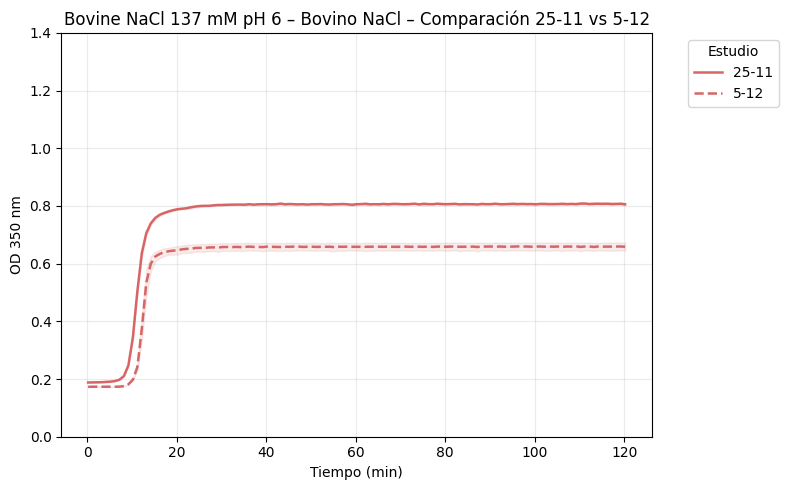

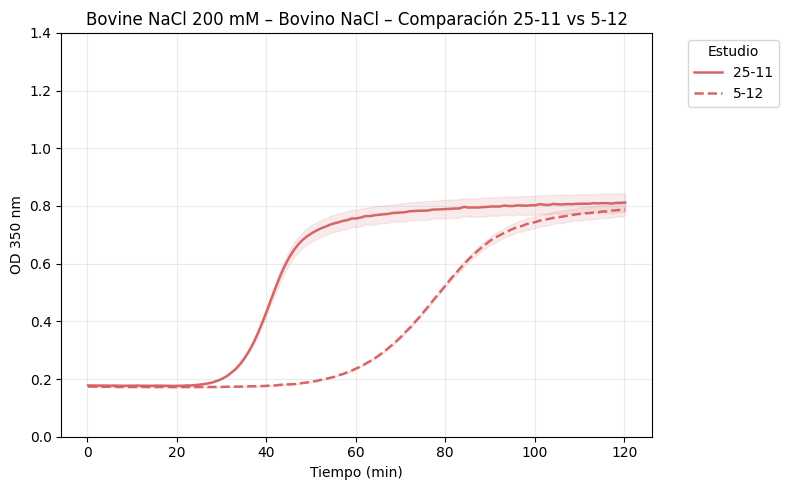

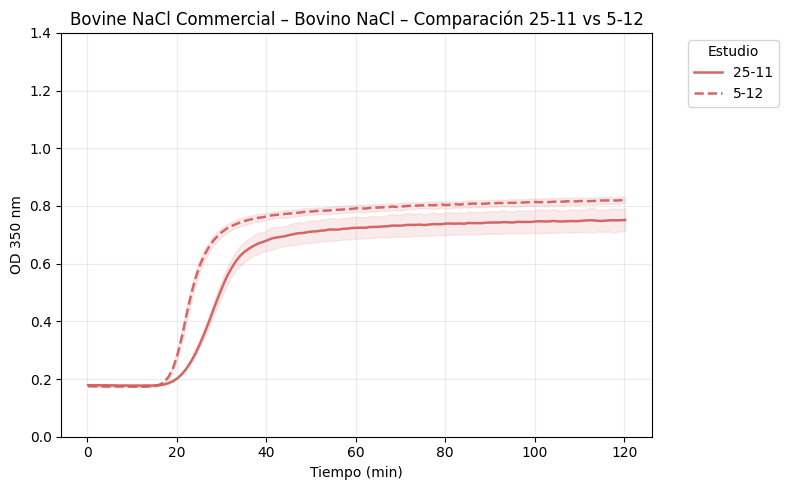

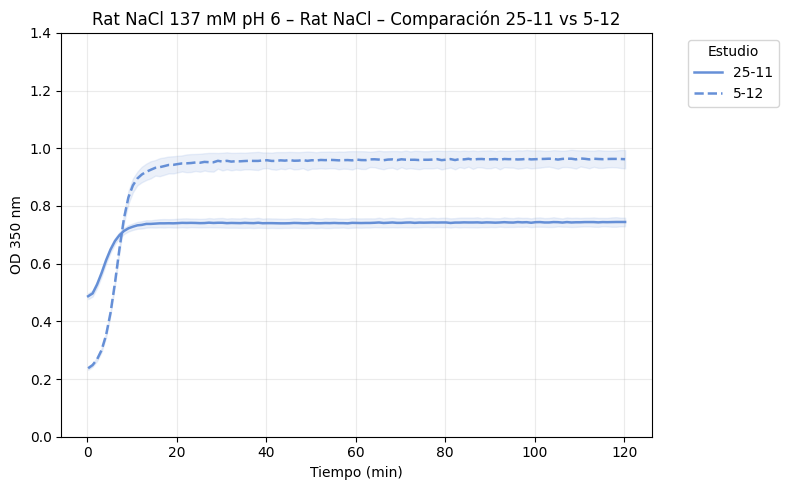

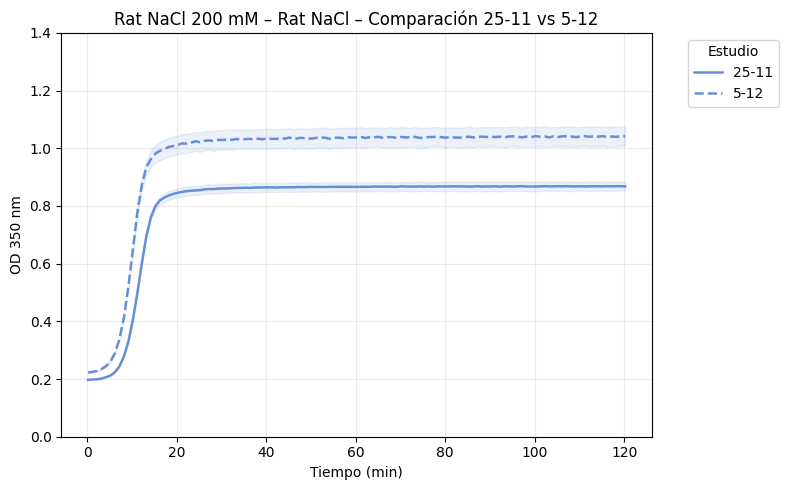

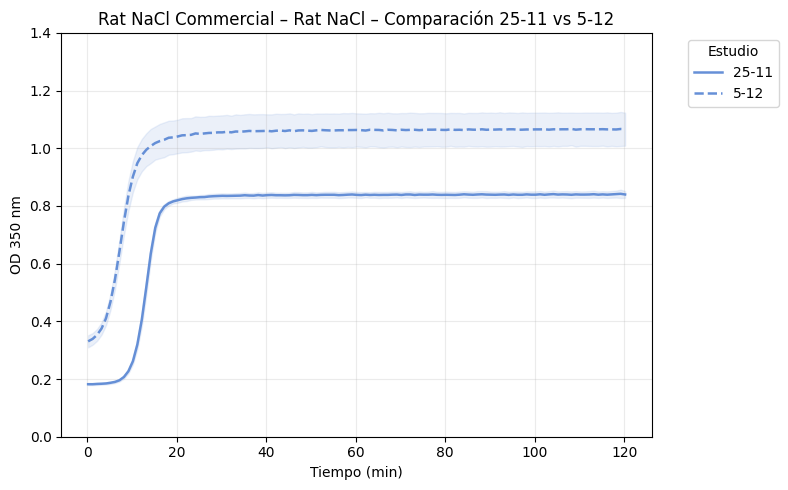

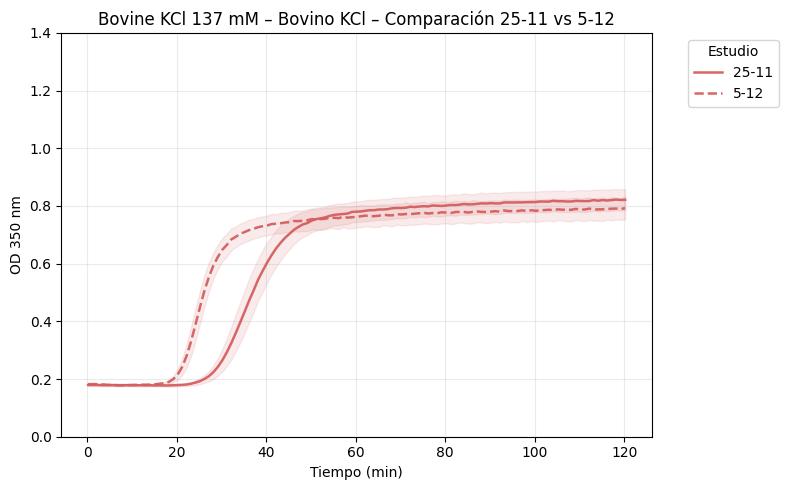

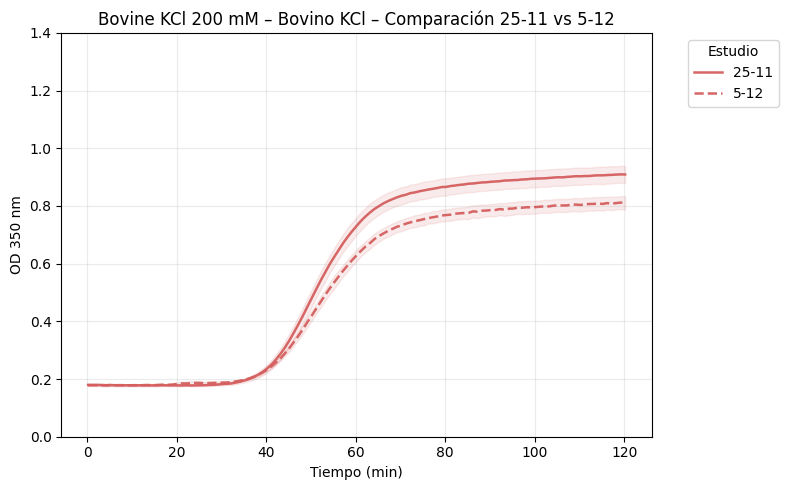

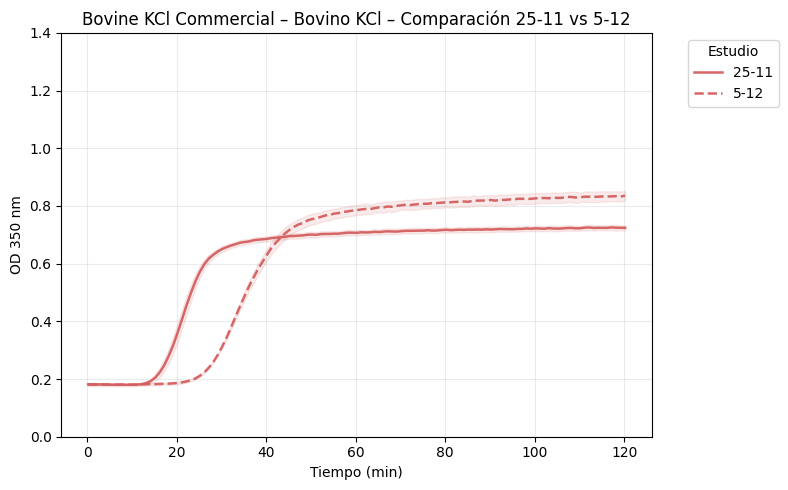

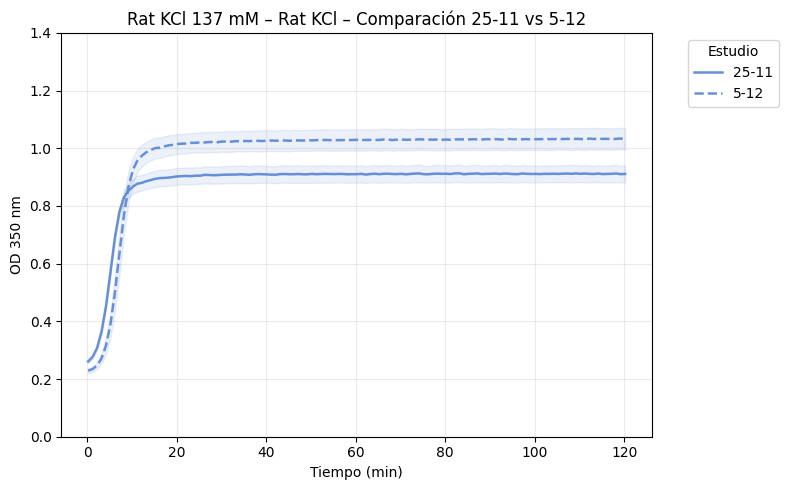

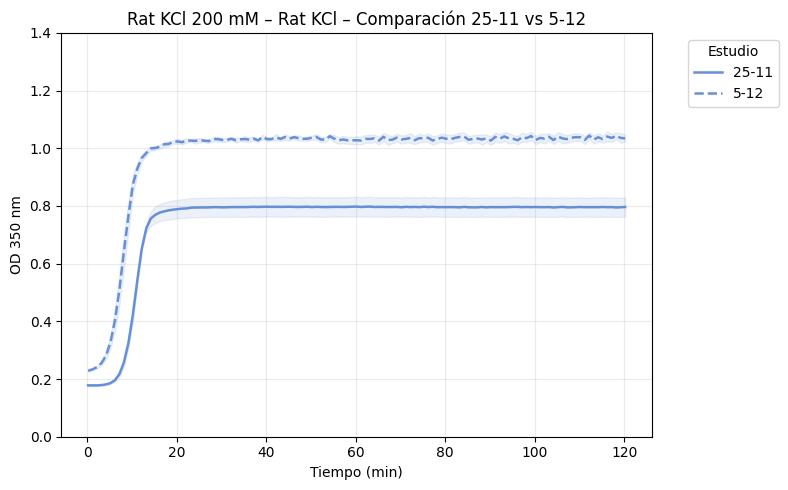

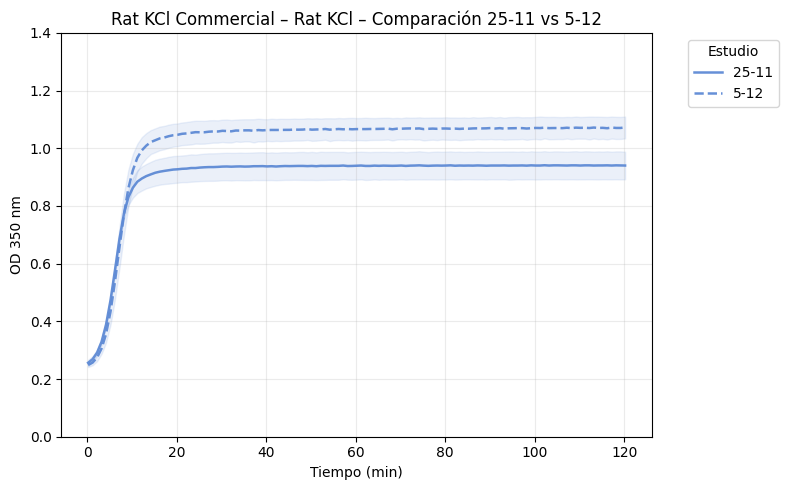

In [3]:
# ================================
# TODAS LAS CONCENTRACIONES
# ================================
# OJO: para 137 mM de NaCl, solo comparamos pH 6 (ignora pH 7 del día 5-12)

# --- NaCl BOVINO: 137 (pH 6), 200, Commercial ---
for conc in ["137 mM", "200 mM", "Commercial"]:
    pH = "pH 6" if conc == "137 mM" else None

    plot_study_comparison(
        all_df,
        species="Bovine",
        salt="NaCl",
        conc=conc,
        pH_filter=pH,
        title_suffix="Bovino NaCl 137 mM"
    )

# --- NaCl RATA: 137 (pH 6), 200, Commercial ---
for conc in ["137 mM", "200 mM", "Commercial"]:
    pH = "pH 6" if conc == "137 mM" else None

    plot_study_comparison(
        all_df,
        species="Rat",
        salt="NaCl",
        conc=conc,
        pH_filter=pH,
        title_suffix="Rat NaCl – Comparación 25-11 vs 5-12"
    )

# --- KCl BOVINO: 137, 200, Commercial ---
# (KCl solo tiene un "pH_group", así que no filtramos por pH)
for conc in ["137 mM", "200 mM", "Commercial"]:
    plot_study_comparison(
        all_df,
        species="Bovine",
        salt="KCl",
        conc=conc,
        pH_filter=None,
        title_suffix="Bovino KCl – Comparación 25-11 vs 5-12"
    )

# --- KCl RATA: 137, 200, Commercial ---
for conc in ["137 mM", "200 mM", "Commercial"]:
    plot_study_comparison(
        all_df,
        species="Rat",
        salt="KCl",
        conc=conc,
        pH_filter=None,
        title_suffix="Rat KCl – Comparación 25-11 vs 5-12"
    )


In [5]:
def plot_study_comparison(df, species, salt, conc, pH_filter=None):
    sub = df[
        (df["species"] == species) &
        (df["salt"] == salt) &
        (df["conc"] == conc)
    ].copy()

    if pH_filter is not None:
        sub = sub[sub["pH_group"] == pH_filter].copy()

    if sub.empty:
        print("No hay datos para:", species, salt, conc, pH_filter)
        return

    def sem(x):
        return x.std(ddof=1) / np.sqrt(len(x))

    stats = (
        sub
        .groupby(["time_min", "study"])["OD"]
        .agg(mean="mean", sem=sem)
        .reset_index()
    )

    plt.figure(figsize=(8,5))

    color = get_color(species, pH_filter if pH_filter is not None else "unaltered/NA")

    for study_name, sub_st in stats.groupby("study"):
        sub_st = sub_st.sort_values("time_min")

        ls = "-" if study_name == "25-11" else "--"

        plt.plot(sub_st["time_min"], sub_st["mean"],
                 color=color, linestyle=ls, linewidth=1.8,
                 alpha=0.95, label=study_name)

        plt.fill_between(sub_st["time_min"],
                         sub_st["mean"] - sub_st["sem"],
                         sub_st["mean"] + sub_st["sem"],
                         color=color, alpha=0.12)

    # 🔥🔥 TÍTULO EXACTO QUE QUIERES 🔥🔥
    # Convertimos "Bovine" → "Bovino", "Rat" → "Rata"
    especie_es = "Bovino" if species == "Bovine" else "Rata"
    titulo = f"{especie_es} {salt} {conc}"

    plt.title(titulo)
    plt.xlabel("Tiempo (min)")
    plt.ylabel("OD 350 nm")
    plt.grid(True, alpha=0.25)
    plt.ylim(0, 1.4)
    plt.legend(title="Estudio", bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()


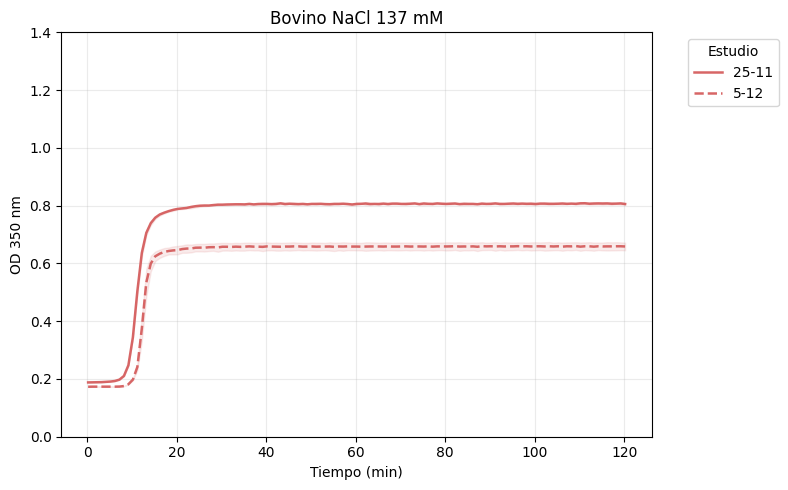

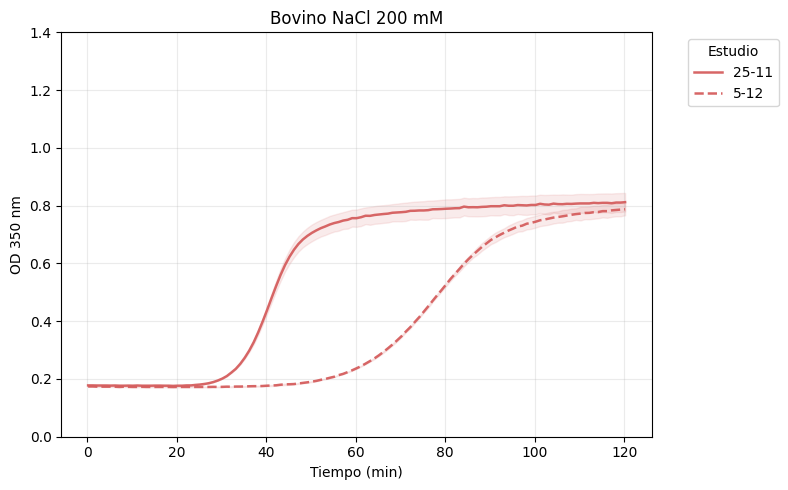

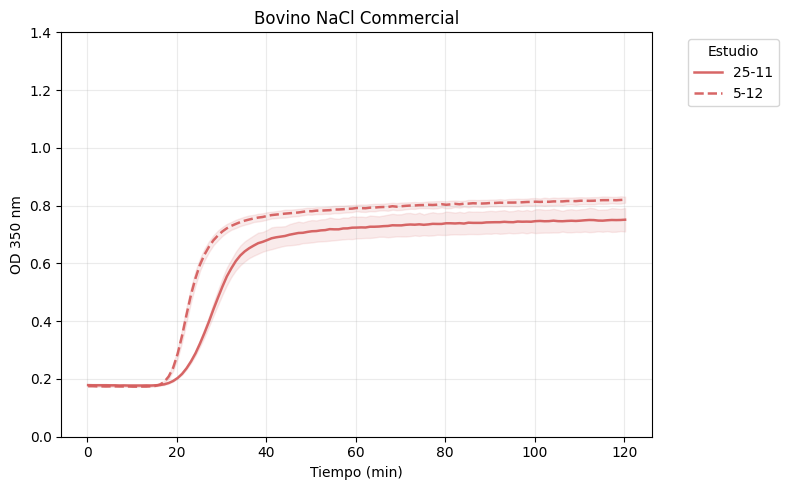

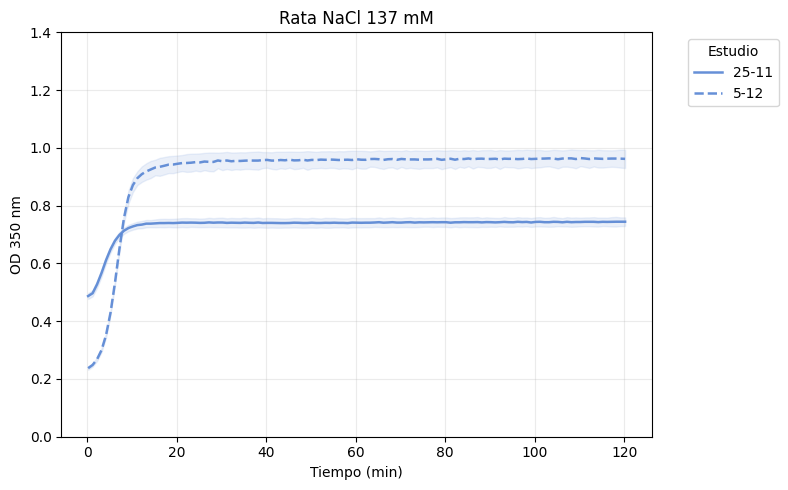

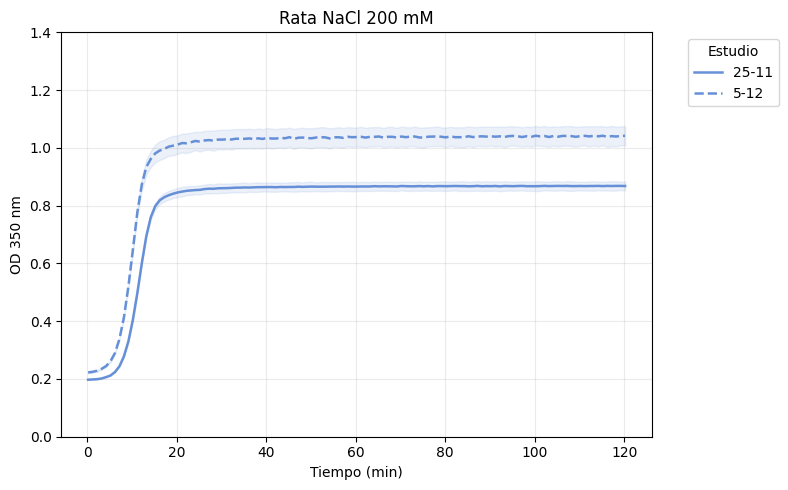

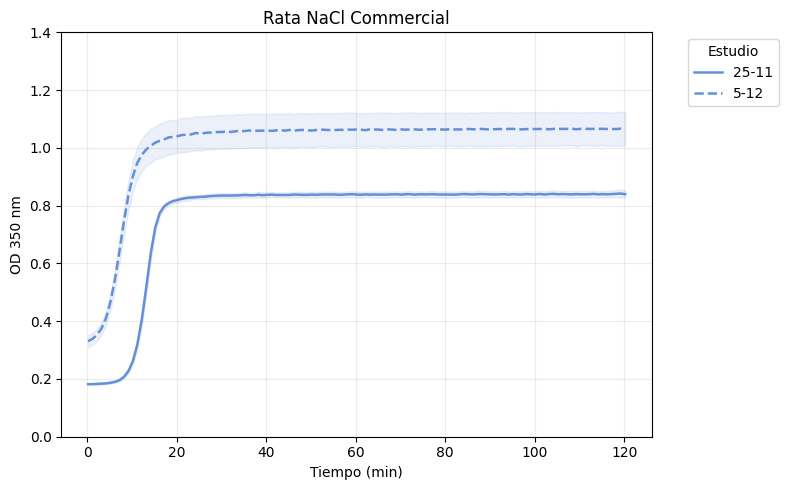

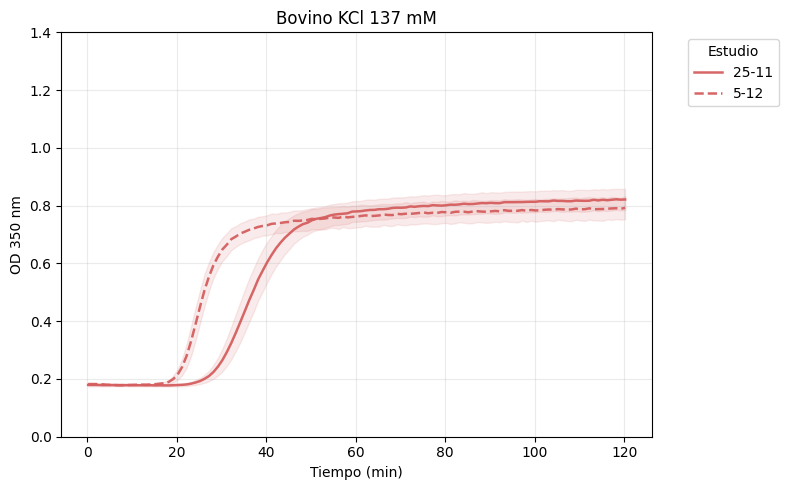

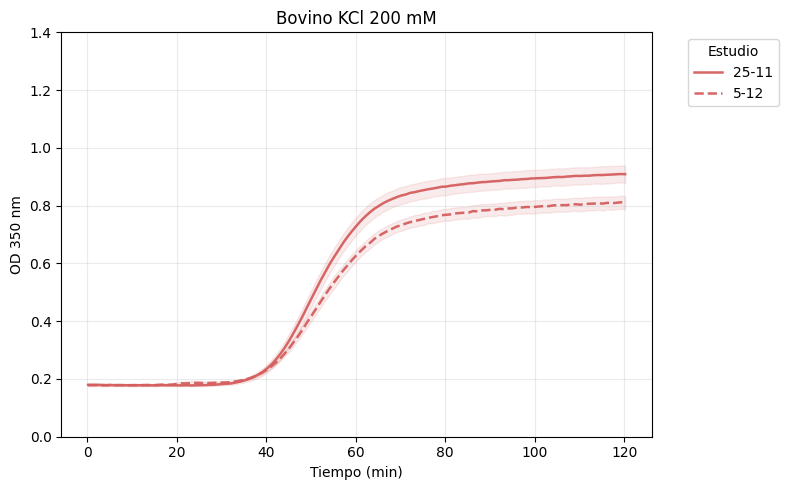

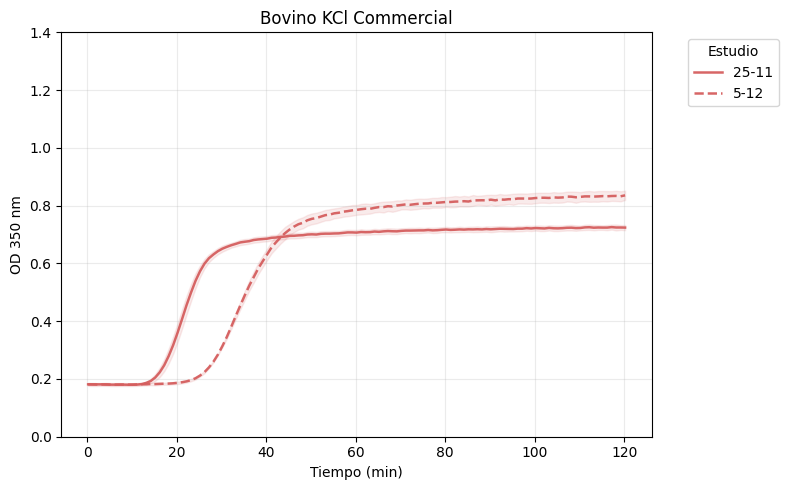

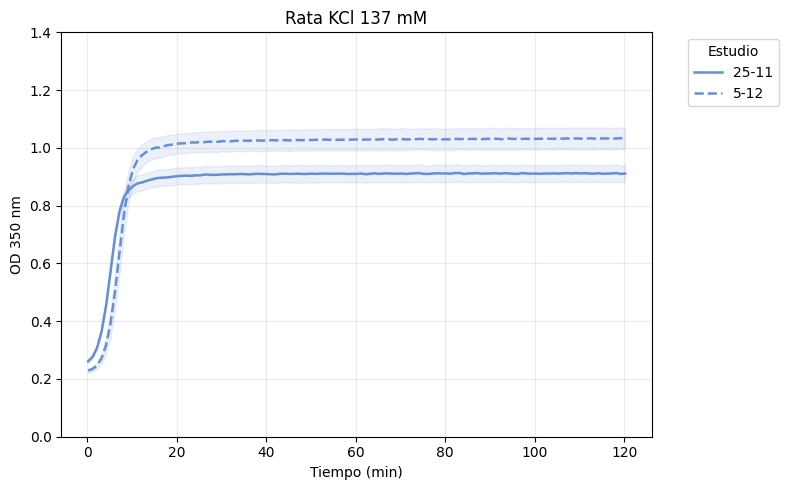

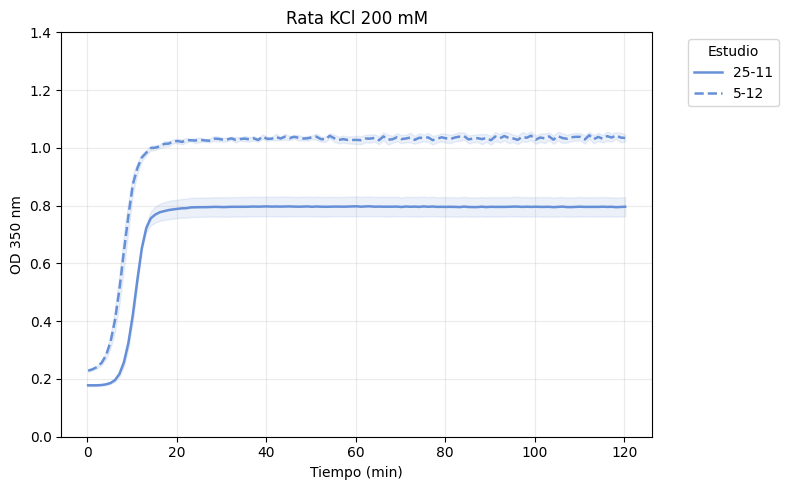

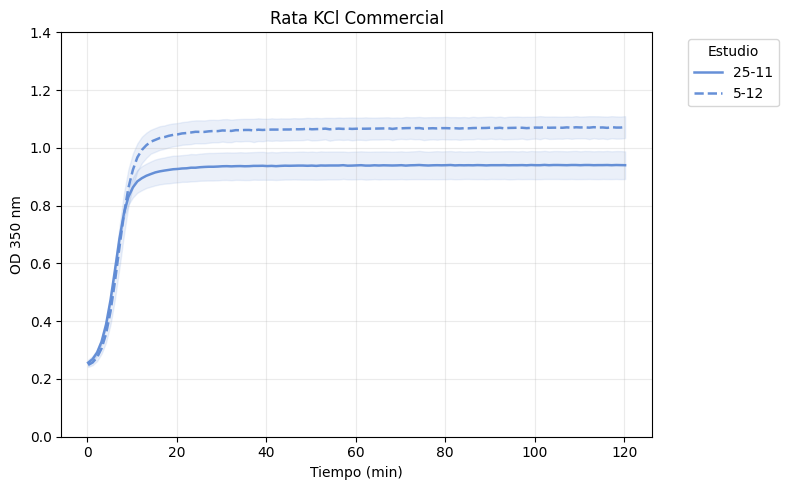

In [6]:
# ---- NaCl BOVINO ----
for conc in ["137 mM", "200 mM", "Commercial"]:
    pH = "pH 6" if conc == "137 mM" else None
    plot_study_comparison(all_df, "Bovine", "NaCl", conc, pH_filter=pH)

# ---- NaCl RATA ----
for conc in ["137 mM", "200 mM", "Commercial"]:
    pH = "pH 6" if conc == "137 mM" else None
    plot_study_comparison(all_df, "Rat", "NaCl", conc, pH_filter=pH)

# ---- KCl BOVINO ----
for conc in ["137 mM", "200 mM", "Commercial"]:
    plot_study_comparison(all_df, "Bovine", "KCl", conc)

# ---- KCl RATA ----
for conc in ["137 mM", "200 mM", "Commercial"]:
    plot_study_comparison(all_df, "Rat", "KCl", conc)


In [9]:
import numpy as np
import matplotlib.pyplot as plt

def plot_conc_both_species(df, salt, conc, pH_filter=None):
    # Filtramos por sal, concentración y solo Bovine/Rat
    sub = df[
        (df["salt"] == salt) &
        (df["conc"] == conc) &
        (df["species"].isin(["Bovine", "Rat"]))
    ].copy()

    if pH_filter is not None:
        sub = sub[sub["pH_group"] == pH_filter].copy()

    if sub.empty:
        print("No hay datos para:", salt, conc, "pH:", pH_filter)
        return

    # sem
    def sem(x):
        return x.std(ddof=1) / np.sqrt(len(x))

    stats = (
        sub
        .groupby(["time_min", "species", "study"])["OD"]
        .agg(mean="mean", sem=sem)
        .reset_index()
    )

    plt.figure(figsize=(8,5))

    # Recorremos especie + estudio
    for (species, study_name), sub_st in stats.groupby(["species", "study"]):
        sub_st = sub_st.sort_values("time_min")

        # color por especie (+ pH si aplica)
        color = get_color(species, pH_filter if pH_filter is not None else "unaltered/NA")

        # estilo de línea: día
        ls = "-" if study_name == "25-11" else "--"



        # línea principal
        plt.plot(sub_st["time_min"], sub_st["mean"],
                 color=color, linestyle=ls, linewidth=1.8,
                 alpha=0.95, label=label)

        # banda SE
        plt.fill_between(sub_st["time_min"],
                         sub_st["mean"] - sub_st["sem"],
                         sub_st["mean"] + sub_st["sem"],
                         color=color, alpha=0.12)

    # Título: 1 por concentración (NaCl 137 mM, etc.)
    titulo = f"{salt} {conc}"
    plt.title(titulo)
    plt.xlabel("Tiempo (min)")
    plt.ylabel("OD 350 nm")
    plt.grid(True, alpha=0.25)
    plt.ylim(0, 1.4)
    plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
    plt.tight_layout()
    plt.show()


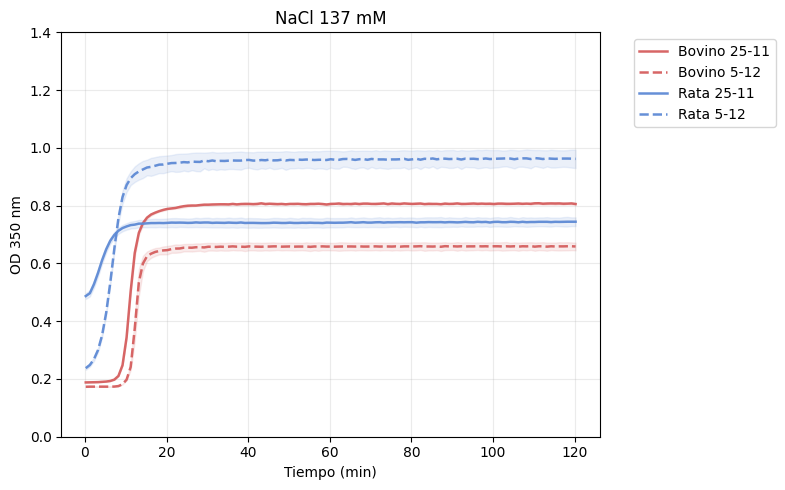

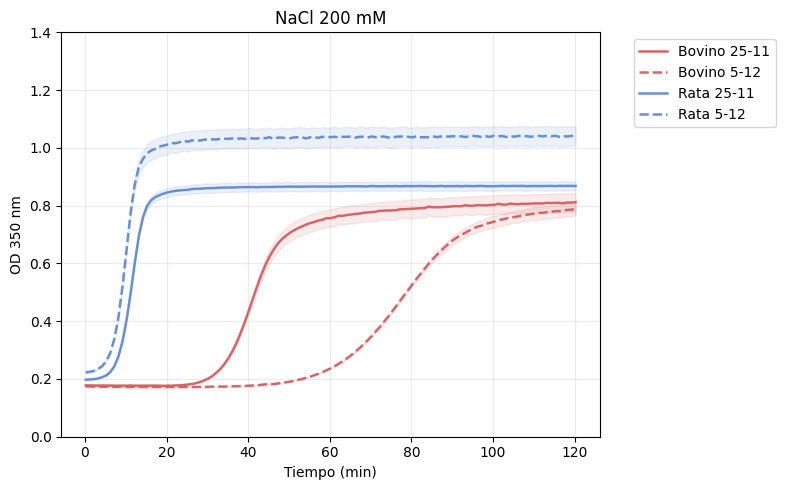

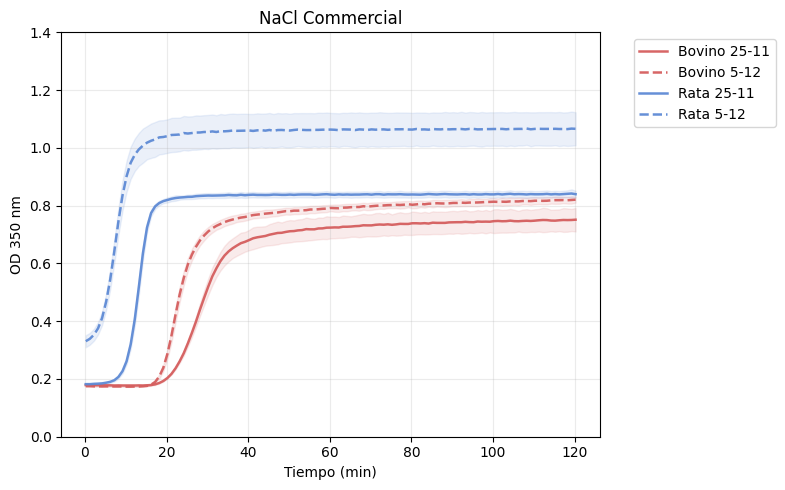

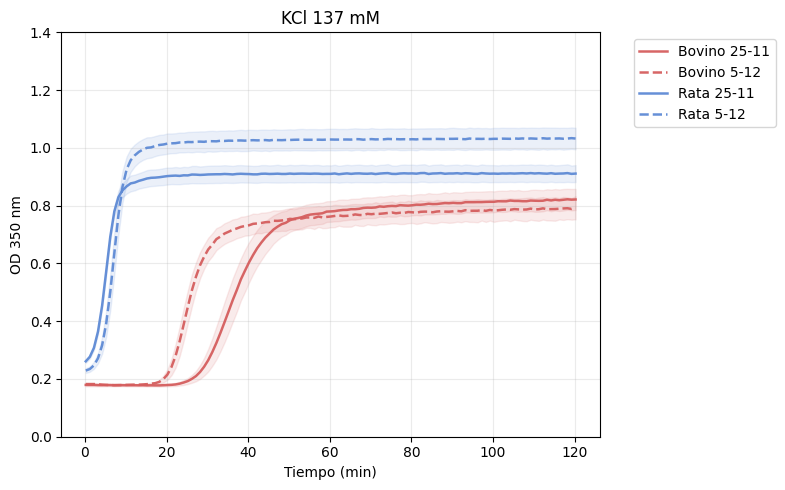

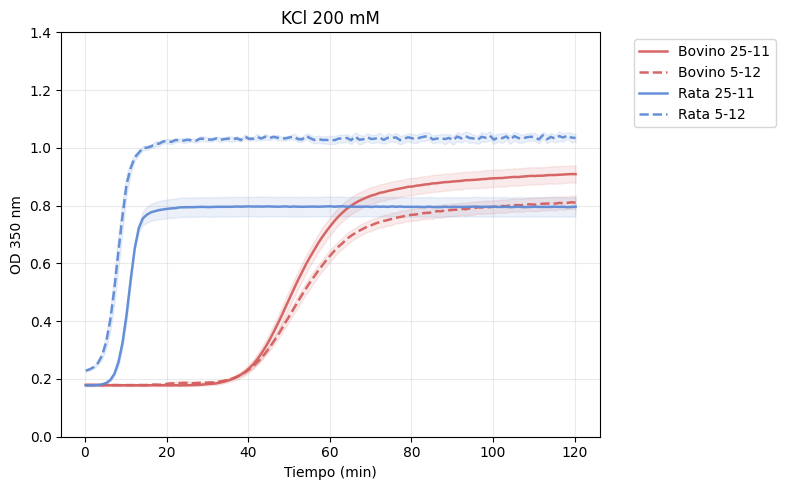

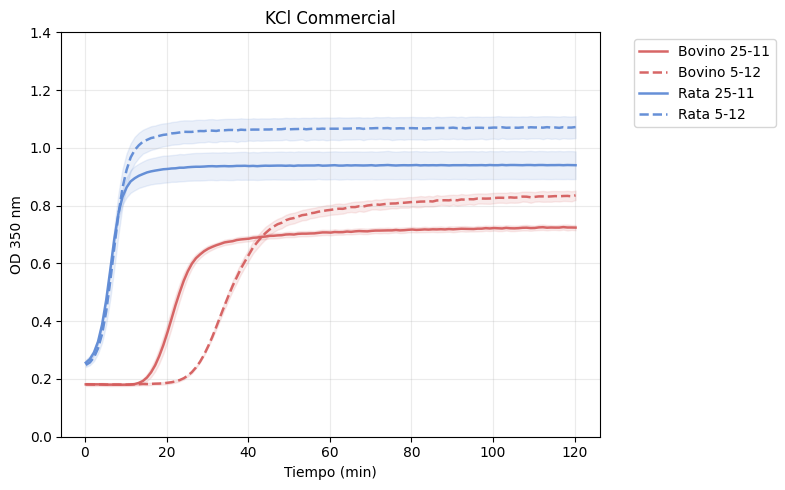

In [8]:
# ===== NaCl: 1 gráfica por concentración, juntando Bovino + Rata =====
for conc in ["137 mM", "200 mM", "Commercial"]:
    # Solo NaCl 137 mM → pH 6
    pH = "pH 6" if conc == "137 mM" else None
    plot_conc_both_species(all_df, salt="NaCl", conc=conc, pH_filter=pH)

# ===== KCl: 1 gráfica por concentración, juntando Bovino + Rata =====
for conc in ["137 mM", "200 mM", "Commercial"]:
    # Para KCl no filtramos pH (se usan todos los datos)
    plot_conc_both_species(all_df, salt="KCl", conc=conc, pH_filter=None)
